## Validation script
Input: 
+ Reference shoreline manually digitized from RapidEye mosaic 
+ Landsat MNDWI images from the same day, generated in GEE and loaded in here 
+ Transect generated at smooth shoreline from the same Landsat image 
+ clipped to a mnauualy digitized polygon represinting the coastal zone 

Output: 
+ transect represinting the change between both shorelines 
+ statistical measures describing the accuary of the Landsat shoreline detection accuary

In [10]:
import os  
import numpy as np
import geopandas as gpd 
import pandas as pd
import rasterio as rio
import shapely as shp
from skimage.filters import threshold_otsu

from coasty import postprocess

In [126]:
data_dir = os.path.join(os.getcwd(),"data")
plot_dir = os.path.join(os.getcwd(),"figures/plots")

crs = "EPSG:3857"

# global Plotting params
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["font.size"] = 11
coastal_blue = "#074e67"
coastal_turquoise = "#05878a"
coastal_beige = "#b6af9d"
coastal_orange = "#ff8f7a"
coastal_grey = "#d7ccc8"

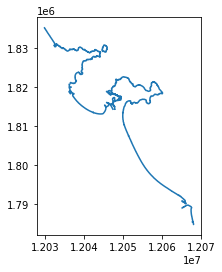

In [63]:
# this validation shoreline has been manually digitized on a RapidEye mosaic which has been coregistered to the corresponding Landsat image 
# using "COREG" from the library arosics (see: Masterarbeit/Code/Co-Registration) 
validation_shoreline = gpd.read_file(os.path.join(os.getcwd(), "shared_data/validation/RE_DaNang_validation_shoreline_coreg.geojson"))
coastal_box = gpd.read_file(os.path.join(os.getcwd(),"shared_data/validation/coastal_zone_validation.shp"))

validation_shoreline = validation_shoreline.to_crs(crs)
coastal_box = coastal_box.to_crs(crs)

validation_shoreline = gpd.clip(validation_shoreline,coastal_box)
validation_shoreline.to_file(
    os.path.join(os.getcwd(), 
    "shared_data/validation/RE_DaNang_validation_shoreline_coreg_clip.geojson"),
    driver="GeoJSON"
    )
validation_shoreline.plot()

In [44]:
coastal_box.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

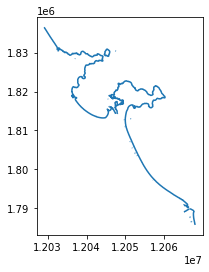

In [45]:
from rasterio.plot import show

# load Landsat MNDWI image 
landsat_path = os.path.join(os.getcwd(),"shared_data/validation/Landsat_validation.tif")
with rio.open(landsat_path,"r") as src: 
    mndwi = src.read(1)
    thres = threshold_otsu(mndwi[~np.isnan(mndwi)])

landsat_shoreline = postprocess.subpixel_contours(landsat_path,thres)
landsat_shoreline = landsat_shoreline.to_crs(crs)
landsat_shoreline = gpd.clip(landsat_shoreline,coastal_box)
landsat_shoreline.to_file(landsat_path+"_shoreline",driver="GeoJSON")
landsat_shoreline.plot()

In [47]:
# load validation transects (which have been generated along the Landsat shoreline (though, the smoothed one along the binary image))
# this decsion has been made, to only validate the precision of the Landsat shoreline positions, not the existence of all shoreline
# segments that might occur at the validation shoreline at not at Landsat... however, one has to decide something in the end. 
# see(03_Prakitka/2020_DLR/Code/Shoreline_detection_postprocessing)
transects = gpd.read_file(os.path.join(os.getcwd(),"shared_data/validation/validation_transects"))
transects = transects.to_crs(crs)

In [48]:
landsat_path = os.path.join(os.getcwd(),"shared_data/validation/Landsat_validation.tif")
landsat_shoreline = gpd.read_file(landsat_path+"_shoreline")
validation_shoreline['year'] = "RapidEye" #year in order to use the function which has been developed for time series intersections
validation_shoreline = validation_shoreline.to_crs(crs)
landsat_shoreline['year'] = "Landsat8"
landsat_shoreline = landsat_shoreline.to_crs(crs)
both_shorelines = pd.concat([validation_shoreline,landsat_shoreline],ignore_index=True)
both_shorelines = both_shorelines.dissolve(by=both_shorelines.year,aggfunc="first")
# intersections of both shoreline with the validation transects 
intersections = postprocess.compute_intersections(transects,both_shorelines,keep="first")
intersections.to_file(os.path.join(os.getcwd(),"shared_data/validation/validation_intersections"),driver="GeoJSON")


990 intersected
991 intersected
992 intersected
993 intersected
994 intersected
995 intersected
996 intersected
997 intersected
998 intersected
999 intersected
1000 intersected
1001 intersected
1002 intersected
1003 intersected
1004 intersected
1005 intersected
1006 intersected
1007 intersected
1008 intersected
1009 intersected
1010 intersected
1011 intersected
1012 intersected
1013 intersected
1014 intersected
1015 intersected
1016 intersected
1017 intersected
1018 intersected
1019 intersected
1020 intersected
1021 intersected
1022 intersected
1023 intersected
1024 intersected
1025 intersected
1026 intersected
1027 intersected
1028 intersected
1029 intersected
1030 intersected
1031 intersected
1032 intersected
1033 intersected
1034 intersected
1035 intersected
1036 intersected
1037 intersected
1038 intersected
1039 intersected
1040 intersected
1041 intersected
1042 intersected
1043 intersected
1044 intersected
1045 intersected
1046 intersected
1047 intersected
1048 intersected
1049 i

In [59]:
import warnings
warnings.filterwarnings('ignore')
validation_change_path = os.path.join(os.getcwd(),"shared_data/validation/validation_change")
if not os.path.exists(validation_change_path):
    # Calcualte shift of the RapidEye shoreline in relation to the Landsat shoreline 
    t_idx = intersections.transect_id.unique().tolist()
    lines, changes = [], []
    for t in t_idx:
        inter = intersections[intersections.transect_id == t]
        if len(inter) > 1:
            landsat = inter[inter.year == "Landsat8"]
            #the transect origins are in seawards direction this time (multiply with -1)
            inter["change"] = (inter.dist_to_transect_origin-landsat.dist_to_transect_origin.iloc[0])*-1
            rapid = inter[inter.year == "RapidEye"]
            changes.append(rapid.change.iloc[0])
            # Create lines between both intersection
            p1 = inter[inter.year == "Landsat8"].geometry.iloc[0]
            p2 = inter[inter.year == "RapidEye"].geometry.iloc[0]
            line = shp.geometry.LineString([p1,p2])
            lines.append(line)
    validation_change = gpd.GeoDataFrame(geometry=lines, crs=crs)
    validation_change['change'] = changes
    validation_change['abs_change'] = abs(validation_change.change)
    validation_change.to_file(validation_change_path,driver="GeoJSON")
else: 
    print("Validation change exists.")
    validation_change = gpd.read_file(validation_change_path)

Validation change exists.


In [72]:
print("Absolute change:")
print(np.median(validation_change.abs_change))
print(np.mean(validation_change.abs_change))
print(np.std(validation_change.abs_change))
print(np.max(validation_change.abs_change)-np.min(validation_change.abs_change))

print("\nReal change:")
print(np.median(validation_change.change))
print(np.mean(validation_change.change))
print(np.std(validation_change.change))

Absolute change:
8.389956165097018
10.644094945053736
10.450165115751322
111.6882292951636

Real change:
-7.458912314582932
-8.649983870020653
12.152386069993288


The median accuray of the Landsat detected shoreline amounts to 8.4 m with a standard deviation (uncertainty) of 10.4 m. Hereby, the median shoreline displacement equals to -7.5 which means, that in average the Landsat shoreline is detected 7 m seawards of the validation shoreline. The standard deviation of the total change is 12.1 m, which in turn implies, that the displacement direction is rather variable. 

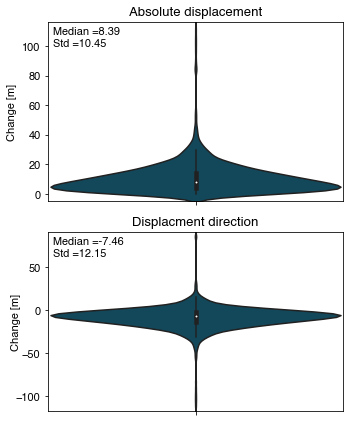

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns 

fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(5, 6))
ax1.set_title("Absolute displacement")
sns.violinplot(data=validation_change.abs_change,ax=ax1,color=coastal_blue)
ax1.set_xticklabels("")
ax1.margins(x=0.01,y=0)
ax1.set_ylabel("Change [m]",labelpad=5)
median1 = np.median(validation_change.abs_change)
std1 = np.std(validation_change.abs_change)
ax1.annotate("Median ="+str(median1.round(2))+"\nStd ="+str(std1.round(2)),xy=(0,1),xycoords="axes fraction",xytext=(5,-5), textcoords="offset points",ha="left",va="top")

ax2.set_title("Displacment direction")
sns.violinplot(data=validation_change.change,ax=ax2,color=coastal_blue)
ax2.set_xticklabels("")
ax2.margins(x=0.01,y=0)
ax2.set_ylabel("Change [m]",labelpad=-5)
median2 = np.median(validation_change.change)
std2 = np.std(validation_change.change)
ax2.annotate("Median ="+str(median2.round(2))+"\nStd ="+str(std2.round(2)),xy=(0,1),xycoords="axes fraction",xytext=(5,-5), textcoords="offset points",ha="left",va="top")

fig.tight_layout()
fig.savefig(os.path.join(plot_dir,"Validation_stats2"), dpi=400)

In [163]:
# could I calculate an R2 of both shorelines? 
y = intersections[intersections.year == "RapidEye"].geometry#dist_to_transect_origin
x = intersections[intersections.year == "Landsat8"].geometry[:-1]#dist_to_transect_origin[:-1]
correlation_matrix = np.corrcoef(x, y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
r_squared

TypeError: unsupported operand type(s) for +: 'Point' and 'Point'

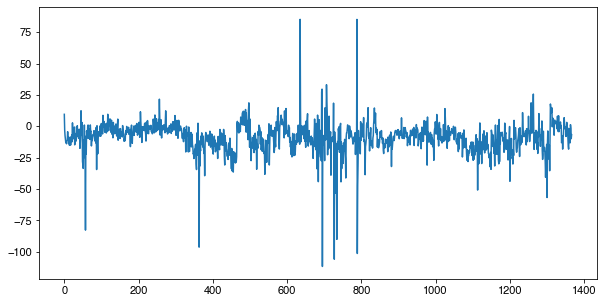

In [161]:
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(range(len(validation_change)),validation_change.change)
#plt.plot(y)

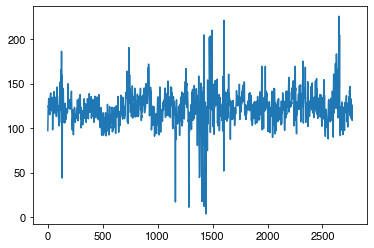